# Problem Set #4

MACS 30000, Dr. Evans

Haihao Guo

## Exercise 1

#### A

In [1]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import requests

In [3]:
income = np.loadtxt('data/incomes.txt')

Text(0,0.5,'Percent of incomes')

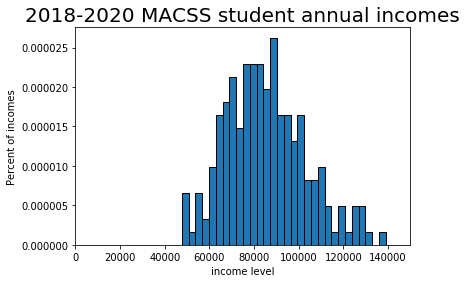

In [4]:
import matplotlib.pyplot as plt

num_bins = 30
count, bins, ignored = plt.hist(income, num_bins, edgecolor='k', density=True)
plt.title('2018-2020 MACSS student annual incomes', fontsize=20)
plt.xlim([0, 150000])
plt.xlabel(r'income level')
plt.ylabel('Percent of incomes')

#### B

In [5]:
def data_moments(xvals):
    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data


def model_moments(mu, sigma):
    
    mean_model = np.exp(mu + (sigma ** 2) / 2)
    std_model = np.sqrt(np.exp(2 * mu + sigma ** 2) * (np.exp(sigma ** 2) - 1))
    
    return mean_model, std_model



def err_vec(xvals, mu, sigma, simple):
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [6]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2) # identity matrix
gmm_args = (income, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args))
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-14, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
results

mu_GMM1= 11.331880866982898  sig_GMM1= 0.20869665246828492


      fun: array([[1.00518646e-15]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.56166349e-08, 3.01504116e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 51
      nit: 12
   status: 0
  success: True
        x: array([11.33188087,  0.20869665])

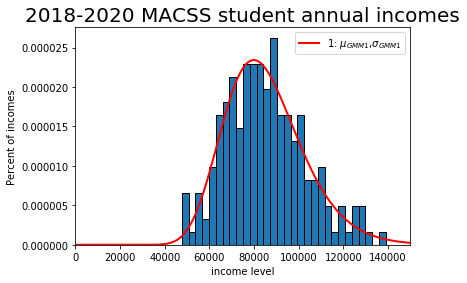

In [7]:
num_bins = 30
count, bins, ignored = plt.hist(income, num_bins, edgecolor='k', density=True)
plt.title('2018-2020 MACSS student annual incomes', fontsize=20)
plt.xlim([0, 150000])
plt.xlabel(r'income level')
plt.ylabel('Percent of incomes')

dist_income = np.linspace(1e-9, 150000, 200000)
plt.plot(dist_income, sts.lognorm.pdf(dist_income, scale = np.exp(mu_GMM1), s = abs(sig_GMM1)),
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper right')

In [8]:
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
func_value = results.fun
mean_data, std_data = data_moments(income)
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1)
print("The value of GMM criterion function at \
the estimated parameter values:\n", func_value)
print('The data moment:')
print('Mean of data points =', mean_data, ', Variance of data points =', std_data)
print('The model moment at the estimated parameter values:')
print('Mean of model =', mean_model, ', Variance of model =', std_model)
err1 = err_vec(income, mu_GMM1, sig_GMM1, False).reshape(2,)
print('Error vector=', err1)

mu_GMM1= 11.331880866982898  sig_GMM1= 0.20869665246828492
The value of GMM criterion function at the estimated parameter values:
 [[1.00518646e-15]]
The data moment:
Mean of data points = 85276.82360625811 , Variance of data points = 17992.542128046523
The model moment at the estimated parameter values:
Mean of model = 85276.82542230906 , Variance of model = 17992.541705444266
Error vector= [ 2.12959497e-08 -2.34876347e-08]


#### C

In [9]:
def get_Err_mat2(pts, mu, sigma, simple=False):

    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, std_model = model_moments(mu, sigma)
    if simple:
        Err_mat[0, :] = pts - mean_model
        Err_mat[1, :] = ((mean_data - pts) ** 2) - std_model
    else:
        Err_mat[0, :] = (pts - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - pts) ** 2) - std_model) / std_model
    
    return Err_mat

In [10]:
Err_mat = get_Err_mat2(income, mu_GMM1, sig_GMM1, False)
VCV2 = (1 / income.shape[0]) * (Err_mat @ Err_mat.T)
print(VCV2)
W_hat2 = lin.inv(VCV2)
print(W_hat2)

[[4.45167045e-02 1.68385256e+03]
 [1.68385256e+03 9.54184435e+08]]
[[ 2.40701670e+01 -4.24767065e-05]
 [-4.24767065e-05  1.12297421e-09]]


In [11]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (income, W_hat2)
results_2 = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results_2.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

mu_GMM2= 11.331880866982898  sig_GMM2= 0.20869665246828492


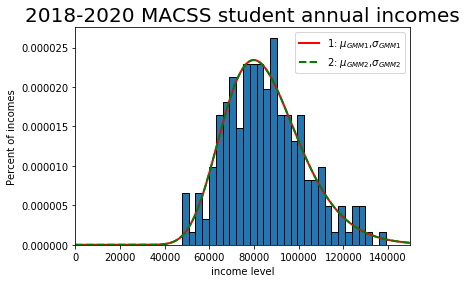

In [12]:
num_bins = 30
count, bins, ignored = plt.hist(income, num_bins, edgecolor='k', density=True)
plt.title('2018-2020 MACSS student annual incomes', fontsize=20)
plt.xlim([0, 150000])
plt.xlabel(r'income level')
plt.ylabel('Percent of incomes')

dist_income = np.linspace(1e-9, 150000, 200000)

plt.plot(dist_income, sts.lognorm.pdf(dist_income, scale = np.exp(mu_GMM1), s = abs(sig_GMM1)),
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper right')

plt.plot(dist_income, sts.lognorm.pdf(dist_income, scale = np.exp(mu_GMM2), s = abs(sig_GMM2)),
         linewidth=2, color='g', label='2: $\mu_{GMM2}$,$\sigma_{GMM2}$', ls ='--')
plt.legend(loc='upper right')

In [13]:
mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2)
func_value2 = results_2.fun
print("The value of GMM criterion function at \
the estimated parameter values:\n", func_value2)
print('The data moment:')
print('Mean of data points =', mean_data, ', Variance of data points =', std_data)
print('The model moment at the estimated parameter values:')
print('Mean of model =', mean_model2, ', Variance of model =', std_model2)
err2 = err_vec(income, mu_GMM2, sig_GMM2, False).reshape(2,)
print('Error vector=', err2)

The value of GMM criterion function at the estimated parameter values:
 [[1.09162838e-14]]
The data moment:
Mean of data points = 85276.82360625811 , Variance of data points = 17992.542128046523
The model moment at the estimated parameter values:
Mean of model = 85276.82542230906 , Variance of model = 17992.541705444266
Error vector= [ 2.12959497e-08 -2.34876347e-08]


#### D

In [14]:
def data_moments3(xvals):
    
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat


def model_moments3(mu, sigma):

    xfx = lambda x: sts.lognorm.pdf(x, scale = np.exp(mu), s = abs(sigma))
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, np.inf)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec3(xvals, mu, sigma, simple):
    
    bpct_1_dat, bpct_2_dat, bpct_3_dat = \
        data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat],[bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = \
        model_moments3(mu, sigma)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion3(params, *args):
    
    mu, sigma = params
    xvals, W = args
    err = err_vec3(xvals, mu, sigma, simple=False)
    crit_val = err.T @ W @ err 
    
    return crit_val

In [15]:
params = np.array([mu_GMM1, sig_GMM1])
print('params=', params)
print(data_moments3(income))
print(model_moments3(mu_GMM1, sig_GMM1))
print(criterion3(params, income, np.eye(3)))

params= [11.33188087  0.20869665]
(0.3, 0.5, 0.2)
(0.30468645806079137, 0.502479816669223, 0.19283372526998577)
[[0.00155252]]


In [16]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat1_3 = np.eye(3)
gmm_args = (income, W_hat1_3)
results_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1_3, sig_GMM1_3 = results_3.x
print('mu_GMM1_3=', mu_GMM1_3, ' sig_GMM1_3=', sig_GMM1_3)

/Users/haihaoguo/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


mu_GMM1_3= 11.335681325706041  sig_GMM1_3= 0.2105984529392122


In [17]:
params = np.array([mu_GMM1_3, sig_GMM1_3])
print('params=', params)
print(data_moments3(income))
print(model_moments3(mu_GMM1_3, sig_GMM1_3))
print(criterion3(params, income, W_hat1_3))

params= [11.33568133  0.21059845]
(0.3, 0.5, 0.2)
(0.3000000057936806, 0.500000006852476, 0.19999998735384358)
[[4.55892124e-15]]


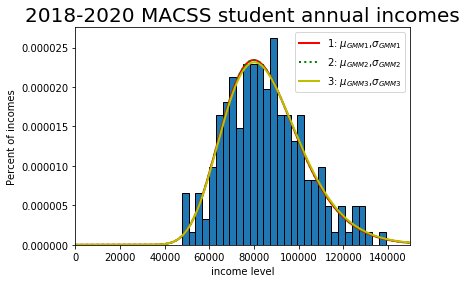

In [18]:
num_bins = 30
count, bins, ignored = plt.hist(income, num_bins, edgecolor='k', density=True)
plt.title('2018-2020 MACSS student annual incomes', fontsize=20)
plt.xlim([0, 150000])
plt.xlabel(r'income level')
plt.ylabel('Percent of incomes')

dist_income = np.linspace(1e-9, 150000, 200000)

plt.plot(dist_income, sts.lognorm.pdf(dist_income, scale = np.exp(mu_GMM1), s = abs(sig_GMM1)),
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper right')

plt.plot(dist_income, sts.lognorm.pdf(dist_income, scale = np.exp(mu_GMM2), s = abs(sig_GMM2)),
         linewidth=2, color='g', label='2: $\mu_{GMM2}$,$\sigma_{GMM2}$', ls=':')
plt.legend(loc='upper right')

plt.plot(dist_income, sts.lognorm.pdf(dist_income, scale = np.exp(mu_GMM1_3), s = abs(sig_GMM1_3)),
         linewidth=2, color='y', label='3: $\mu_{GMM3}$,$\sigma_{GMM3}$')
plt.legend(loc='upper right')

In [19]:
print('mu_GMM1_3=', mu_GMM1_3, ' sig_GMM1_3=', sig_GMM1_3)
func_value_3 = results_3.fun
print("The value of GMM criterion function at \
the estimated parameter values:\n", func_value_3)
print('The data moment:', data_moments3(income))
print('The model moment at the estimated parameter values:', model_moments3(mu_GMM1_3, sig_GMM1_3))
err1_3 = err_vec(income, mu_GMM1_3, sig_GMM1_3, False).reshape(2,)
print('Error vector=', err1_3)

mu_GMM1_3= 11.335681325706041  sig_GMM1_3= 0.2105984529392122
The value of GMM criterion function at the estimated parameter values:
 [[4.55892124e-15]]
The data moment: (0.3, 0.5, 0.2)
The model moment at the estimated parameter values: (0.3000000057936806, 0.500000006852476, 0.19999998735384358)
Error vector= [0.00420802 0.01356259]


#### E

In [20]:
def get_Err_mat3(pts, mu, sigma, simple=False):

    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = \
        model_moments3(mu, sigma)
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod
    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    
    return Err_mat

In [21]:
Err_mat3 = get_Err_mat3(income, mu_GMM1_3, sig_GMM1_3, False)
VCV2_3 = (1 / income.shape[0]) * (Err_mat3 @ Err_mat3.T)
print(VCV2_3)
# We use the pseudo-inverse command here because the VCV matrix is poorly conditioned
W_hat2_3 = lin.pinv(VCV2_3)
print(W_hat2_3)

[[ 2.33333324 -0.99999997 -1.00000004]
 [-0.99999997  0.99999997 -1.00000005]
 [-1.00000004 -1.00000005  4.00000051]]
[[ 0.25761774 -0.1495845  -0.01246537]
 [-0.1495845   0.11911357 -0.07340719]
 [-0.01246537 -0.07340719  0.20221605]]


In [22]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
gmm_args = (income, W_hat2_3)
results_4 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-2, None)))
mu_GMM2_3, sig_GMM2_3 = results_4.x
print('mu_GMM2_3=', mu_GMM2_3, ' sig_GMM2_3=', sig_GMM2_3)

/Users/haihaoguo/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


mu_GMM2_3= 11.335681326359209  sig_GMM2_3= 0.21059845215306566


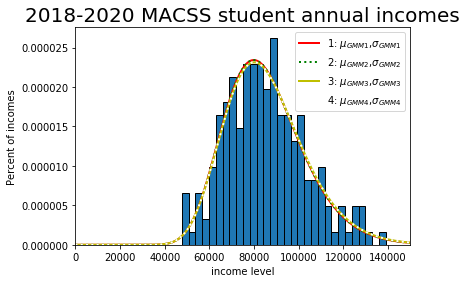

In [23]:
num_bins = 30
count, bins, ignored = plt.hist(income, num_bins, edgecolor='k', density=True)
plt.title('2018-2020 MACSS student annual incomes', fontsize=20)
plt.xlim([0, 150000])
plt.xlabel(r'income level')
plt.ylabel('Percent of incomes')

dist_income = np.linspace(1e-9, 150000, 200000)

plt.plot(dist_income, sts.lognorm.pdf(dist_income, scale = np.exp(mu_GMM1), s = abs(sig_GMM1)),
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper right')

plt.plot(dist_income, sts.lognorm.pdf(dist_income, scale = np.exp(mu_GMM2), s = abs(sig_GMM2)),
         linewidth=2, color='g', label='2: $\mu_{GMM2}$,$\sigma_{GMM2}$', ls=':')
plt.legend(loc='upper right')

plt.plot(dist_income, sts.lognorm.pdf(dist_income, scale = np.exp(mu_GMM1_3), s = abs(sig_GMM1_3)),
         linewidth=2, color='y', label='3: $\mu_{GMM3}$,$\sigma_{GMM3}$')
plt.legend(loc='upper right')

plt.plot(dist_income, sts.lognorm.pdf(dist_income, scale = np.exp(mu_GMM2_3), s = abs(sig_GMM2_3)),
         linewidth=2, color='w', label='4: $\mu_{GMM4}$,$\sigma_{GMM4}$', ls=':')
plt.legend(loc='upper right')

In [24]:
print('mu_GMM2_3=', mu_GMM2_3, ' sig_GMM2_3=', sig_GMM2_3)
func_value_4 = results_4.fun
print("The value of GMM criterion function at \
the estimated parameter values:\n", func_value_4)
print('The data moment:', data_moments3(income))
print('The model moment at the estimated parameter values:', model_moments3(mu_GMM2_3, sig_GMM2_3))

mu_GMM2_3= 11.335681326359209  sig_GMM2_3= 0.21059845215306566
The value of GMM criterion function at the estimated parameter values:
 [[1.0040159e-15]]
The data moment: (0.3, 0.5, 0.2)
The model moment at the estimated parameter values: (0.30000000403469335, 0.5000000086227223, 0.19999998734258453)


#### F

In [27]:
mu = [mu_GMM1,mu_GMM2,mu_GMM1_3,mu_GMM2_3]
sig = [sig_GMM1,sig_GMM2,sig_GMM1_3,sig_GMM2_3]
funcv = [func_value, func_value2, func_value_3, func_value_4]
df1 = pd.DataFrame({"mu":mu,"sigma":sig,"Value of GMM func":funcv}
            ,index=['2 moments with Identity Matrix','2 moments with Weighted Matrix',
                   '3 moments with Identity Matrix','3 moments with Weighted Matrix']) \
             .astype(float)

print(df1)

min(df1['Value of GMM func'])

                                       mu     sigma  Value of GMM func
2 moments with Identity Matrix  11.331881  0.208697       1.005186e-15
2 moments with Weighted Matrix  11.331881  0.208697       1.091628e-14
3 moments with Identity Matrix  11.335681  0.210598       4.558921e-15
3 moments with Weighted Matrix  11.335681  0.210598       1.004016e-15


1.0040159007259268e-15

We could know from above that the best GMM estimation in this case is the 4th method, 3 moments with Weighted Matrix.

## Exercise 2

#### A

In [29]:
df = pd.read_csv("data/sick.txt").astype('float64')

In [30]:
def err_vec_lr(y, x1, x2, x3, b0, b1, b2, b3, simple):
    y_hat = b0 + b1*x1 + b2*x2 + b3*x3
    if simple:
        return y - y_hat
    else:
        return (y - y_hat)/ y_hat
    
def crit_lr(params, *args):
    b0, b1, b2, b3 = params
    y, x1, x2, x3, W = args
    err = err_vec_lr(y, x1, x2, x3, b0, b1, b2, b3, True)
    crit_val = err.T @ W @ err
    return crit_val

params_init = np.array([1, 0, 0, 0])
W_hat = np.eye(200)
gmm_args = (df.sick, df.age, df.children, df.avgtemp_winter, W_hat)
res = opt.minimize(crit_lr, params_init, args=(gmm_args),tol=1e-14, method='L-BFGS-B')
b0, b1, b2, b3 = res.x
val_crit = res.fun
print("Estimate of b0: ",b0)
print("Estimate of b1: ",b1)
print("Estimate of b2: ",b2)
print("Estimate of b3: ",b3)
print('Value of GMM criterion function: ',val_crit)

Estimate of b0:  0.2516448638485754
Estimate of b1:  0.01293347099027143
Estimate of b2:  0.4005009844080149
Estimate of b3:  -0.009991709726951003
Value of GMM criterion function:  0.001821289806059263
